## 알아서 데이터를 웹에서 다운로드 하게 돼 있습니다. 따로 웹에서 데이터를 안 가져오셔도 됩니다.

## 아래 패키지들 설치 필요합니다.

## 아마 hashlib 말고는 다 설치가 돼 있을 것 같습니다.
## tonic_custom은 이 작업 폴더에 있으니까 설치 안하셔도 됩니다.

## 알아서 데이터를 웹에서 다운로드 하게 돼 있습니다. 따로 웹에서 데이터를 안 가져오셔도 됩니다.

## 일단 그냥 RUN 해보시면 바로 되게 해놨습니다.


In [1]:
import os
import torch
import matplotlib.pyplot as plt
import hashlib

import tonic_custom as tonic
from tonic_custom import DiskCachedDataset

In [2]:
def data_loader(which_data, data_path, BATCH, IMAGE_SIZE, TIME, dvs_clipping, dvs_duration, exclude_class, merge_polarities, 
                denoise_on, my_seed, extra_train_dataset, num_workers, chaching_on, pin_memory):

    ### DVS_GESTURE_TONIC ########################################################################################################
    ### DVS_GESTURE_TONIC ########################################################################################################
    ### DVS_GESTURE_TONIC ########################################################################################################
    ### DVS_GESTURE_TONIC ########################################################################################################
    if (which_data == 'DVS_GESTURE_TONIC'):
        data_dir = data_path
        
        train_dataset_list = []
        # extra_train_dataset 이거 개수만큼 train dataset 더 가져옵니다.
        for extra_train_index in range(extra_train_dataset+1):
            # classes = [
            #     "hand_clapping",
            #     "right_hand_wave",
            #     "left_hand_wave",
            #     "right_arm_clockwise",
            #     "right_arm_counter_clockwise",
            #     "left_arm_clockwise",
            #     "left_arm_counter_clockwise",
            #     "arm_roll",
            #     "air_drums",
            #     "air_guitar",
            #     "other_gestures",
            # ]
            train_compose = []

            # polarity 없애기
            if merge_polarities == True:
                train_compose.append(tonic.transforms.MergePolarities()) 
            
            # 샘플 짜르기
            crop_max_time = 100_000 + extra_train_index*dvs_duration*(TIME+1) + dvs_duration*(TIME+1) + 100_000
            crop_min_time = 100_000 + extra_train_index*dvs_duration*(TIME+1)
            train_compose.append(tonic.transforms.CropTime(max=crop_max_time))
            train_compose.append(tonic.transforms.CropTime(min=crop_min_time))

            # denoise 하기
            if denoise_on == True:
                train_compose.append(tonic.transforms.Denoise(filter_time=10_000)) # 10_000 # 낮을수록 더 많이 거름
            
            # 이미지 크기 조정
            train_compose.append(tonic.transforms.Downsample(spatial_factor=IMAGE_SIZE/tonic.datasets.DVSGesture.sensor_size[0]))
            train_compose.append(tonic.transforms.ToFrame(
                sensor_size=(IMAGE_SIZE,IMAGE_SIZE,2),
                time_window=dvs_duration, 
                include_incomplete=False))
            
            train_transform = tonic.transforms.Compose(train_compose)

            # test dataset #####################################################################################################
            # test dataset은 extra_train_index에 상관없이 항상 동일한 crop_max_time, crop_min_time을 사용합니다.
            # 따라서 for문 밖으로 빼도 되는데 밑에 caching에 문제 생길까봐 그냥 놔뒀습니다.
            test_compose = []
            if merge_polarities == True:
                test_compose.append(tonic.transforms.MergePolarities()) #polarity 없애기
            crop_max_time_test = 100_000 + dvs_duration*(TIME+1)
            crop_min_time_test = 100_000
            test_compose.append(tonic.transforms.CropTime(max=crop_max_time_test))
            test_compose.append(tonic.transforms.CropTime(min=crop_min_time_test))
            if denoise_on == True:
                test_compose.append(tonic.transforms.Denoise(filter_time=10_000)) # 10_000 # 낮을수록 더 많이 거름
            test_compose.append(tonic.transforms.Downsample(spatial_factor=IMAGE_SIZE/tonic.datasets.DVSGesture.sensor_size[0]))
            test_compose.append(tonic.transforms.ToFrame(
                sensor_size=(IMAGE_SIZE,IMAGE_SIZE,2),
                time_window=dvs_duration, 
                include_incomplete=False))
            test_transform = tonic.transforms.Compose(test_compose)
            # test dataset #####################################################################################################


            train_dataset_temp = tonic.datasets.DVSGesture(data_dir, train=True, transform=train_transform, clipping = dvs_clipping, time = TIME, exclude_class = exclude_class, crop_max_time = crop_max_time)
            test_dataset = tonic.datasets.DVSGesture(data_dir, train=False, transform=test_transform, clipping = dvs_clipping, time = TIME, exclude_class = exclude_class, crop_max_time = crop_max_time_test)

            ## disk에 dataset caching하기 ###################################################################
            train_transform_settings = {
                'train_transform': train_transform,
                'test_transform': test_transform,
                'clipping': dvs_clipping,
                'time': TIME,
                'exclude_class': exclude_class,
            }
            settings_str = str(train_transform_settings)
            dataset_hash = hashlib.md5(settings_str.encode()).hexdigest()
            print(f'dataset_hash = {dataset_hash}')

            # cache 폴더가 없으면 생성
            os.makedirs(f"{data_dir}/DVSGesture/cache/", exist_ok=True)

            my_cache_path = f"{data_dir}/DVSGesture/cache/fast_dataloading_{dataset_hash}"
            if os.path.exists(my_cache_path):
                print('cache path exists')
            else:
                print('cache path doesn\'t exist')
                os.mkdir(my_cache_path)
                os.mkdir(f"{my_cache_path}/train")
                os.mkdir(f"{my_cache_path}/test")

            if chaching_on == True:
                train_dataset_list.append(DiskCachedDataset(train_dataset_temp, cache_path=f"{my_cache_path}/train"))
                test_dataset = DiskCachedDataset(test_dataset, cache_path=f"{my_cache_path}/test")
            else: 
                train_dataset_list.append(train_dataset_temp)
                ################################################################################################
        
        train_dataset = torch.utils.data.ConcatDataset(train_dataset_list)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle = True, num_workers=num_workers, drop_last=False, generator=torch.Generator().manual_seed(my_seed), pin_memory = pin_memory)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, shuffle = False, num_workers=num_workers, drop_last=False, pin_memory = pin_memory)
        
        in_channel = 1 if merge_polarities == True else 2
        CLASS_NUM = 10 if exclude_class == True else 11

        train_data_count = len(train_dataset) 
    
    ### NMNIST_TONIC ########################################################################################################
    ### NMNIST_TONIC ########################################################################################################
    ### NMNIST_TONIC ########################################################################################################
    ### NMNIST_TONIC ########################################################################################################
    elif (which_data == 'NMNIST_TONIC'):
        data_dir = data_path 
        assert extra_train_dataset == 0, 'NMNIST는 extra_train_dataset을 지원하지 않습니다.'
        
        compose = []

        # polarity 없애기
        if merge_polarities == True:
            compose.append(tonic.transforms.MergePolarities()) #polarity 없애기

        # 샘플 짜르기
        compose.append(tonic.transforms.CropTime(max=(10_000 + dvs_duration*(TIME+1))+100_000))
        compose.append(tonic.transforms.CropTime(min=(10_000)))

        # denoise 하기
        if denoise_on == True:
            compose.append(tonic.transforms.Denoise(filter_time=10_000)) # 10_000 # 낮을수록 더 많이 거름

        # 이미지 크기 조정
        compose.append(tonic.transforms.Downsample(spatial_factor=IMAGE_SIZE/tonic.datasets.NMNIST.sensor_size[0]))
        compose.append(tonic.transforms.ToFrame(
            sensor_size=(IMAGE_SIZE,IMAGE_SIZE,2),
            time_window=dvs_duration, 
            include_incomplete=False))
        
        transform = tonic.transforms.Compose(compose)

        train_dataset = tonic.datasets.NMNIST(data_dir, train=True, transform=transform, clipping = dvs_clipping, time = TIME)
        test_dataset = tonic.datasets.NMNIST(data_dir, train=False, transform=transform, clipping = dvs_clipping, time = TIME)
        

        ## disk에 dataset caching하기 ###################################################################
        transform_settings = {
            'train_transform': transform,
            'test_transform': transform,
            'clipping': dvs_clipping,
            'time': TIME
        }
        settings_str = str(transform_settings)
        dataset_hash = hashlib.md5(settings_str.encode()).hexdigest()
        print(f'dataset_hash = {dataset_hash}')

        # cache 폴더가 없으면 생성
        os.makedirs(f"{data_dir}/DVSGesture/cache/", exist_ok=True)
        
        my_cache_path = f"{data_dir}/NMNIST/cache/fast_dataloading_{dataset_hash}"
        if os.path.exists(my_cache_path):
            print('cache path exists')
        else:
            print('cache path doesn\'t exist')
            os.mkdir(my_cache_path)
            os.mkdir(f"{my_cache_path}/train")
            os.mkdir(f"{my_cache_path}/test")

        if chaching_on == True:
            train_dataset = DiskCachedDataset(train_dataset, cache_path=f"{my_cache_path}/train")
            test_dataset = DiskCachedDataset(test_dataset, cache_path=f"{my_cache_path}/test")
        else:
            train_dataset = train_dataset
            test_dataset = test_dataset
        ################################################################################################



        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle = True, num_workers=num_workers, drop_last=False, generator=torch.Generator().manual_seed(my_seed), pin_memory = pin_memory)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, shuffle = False, num_workers=num_workers, drop_last=False, pin_memory = pin_memory)

        in_channel = 1 if merge_polarities == True else 2
        CLASS_NUM = 10
        train_data_count = len(train_dataset) 

    else:
        assert False, 'which_data가 잘못됨.'

    return train_loader, test_loader, in_channel, CLASS_NUM, train_data_count





In [3]:
train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM, train_data_count = data_loader(
        which_data = 'DVS_GESTURE_TONIC', 
        # 'DVS_GESTURE_TONIC' or 'NMNIST_TONIC' 

        data_path = '/data2', 
        # '/data2' or '/data3', etc. # gpu 서버 경로 설정. nfs 로 해놓지만 않으면 됩니다.

        BATCH = 16, 
        # 아무거나

        IMAGE_SIZE = 128, 
        # 아무거나 # DVS_GESTURE_TONIC 128, # NMNIST_TONIC 34가 원본이긴 합니다만 원하는 사이즈 하셔도 됩니다. 저는 14로 했습니다.
        # 다만 down_sizing하면 down_pooling 된 스파이크를 모두 더합니다. max_pool이 아니고 sum_pool(?)입니다.

        TIME = 8, 
        # 아무거나

        dvs_clipping = 1,
        # 0 이상 아무거나
        # 이 숫자보다 크거나 같을 때 해당 칸을 1, 작으면 0으로 clpping 됩니다. dvs_duration 시간 동안 스파이크 개수가 누적되기도하고
        # IMAGE_SIZE를 작게하면 sum_pooling 되어 누적되기도 하니까 이 dvs_clipping을 1이상으로 설정해야 됩니다.
        # 만약 dvs_clipping을 0으로 하면 clipping은 하지않고 모든 스파이크를 다 더한 정수값이 나옵니다.  

        dvs_duration = 250_000,
        # 아무거나 

        exclude_class = True,
        # DVS-Gesture의 11번째 클래스를 배제합니다. NMNIST와는 무관합니다.

        merge_polarities = True,
        # True로 하면 polarity를 합칩니다. 즉 negative polarity와 positive polarity의 스파이크를 합쳐서 첫번째 채널에 둡니다.
        # 두번째 채널의 값은 모두 0으로 둡니다. 채널 차원 자체는 2로 유지됩니다.!

        denoise_on = False,
        # True로 하면 denoise가 적용됩니다. caching 때문에 처음 한 epoch만 오래 걸리고 그 다음부터는 빠릅니다.

        my_seed = 1,
        # seed 지정입니다. train_loader 셔플 시드 값입니다.

        extra_train_dataset = 0,
        # train dataset에서 남은 타임 동안에서 데이터를 더 가져옵니다. 즉, 샘플개수가 늘어나는 효과가 있습니다.
        # test_dataset에는 적용되지 않습니다.
        # DVS_GESTURE_TONIC에서만 사용됩니다.

        num_workers = 2,
        # 2 추천
        # 저는 그냥 2로 합니다. 이걸 해야 무슨 CPU(GPU아님)를 덜 먹었었나 그랬습니다.

        chaching_on = True,
        # True 추천
        # 이걸 해야 데이터 캐싱이 가능합니다.

        pin_memory = True,
        # True 추천
        # 저는 그냥 2로 합니다. 이걸 해야 무슨 CPU(GPU아님)를 덜 먹었었나 그랬습니다.
        
        ) 

이 데이터셋의 데이터 개수는 979 입니다. (test set은 그대로입니다.)
이 데이터셋의 데이터 개수는 239 입니다. (test set은 그대로입니다.)
dataset_hash = 112e701dbef1dad7a1e76b9ba22db32e
cache path exists


inputs.shape : torch.Size([16, 8, 2, 128, 128]) [batch, time, channel, height, width]
targets.shape: torch.Size([16]) [batch]
1st sample shape: torch.Size([8, 2, 128, 128]) [time, channel, height, width]


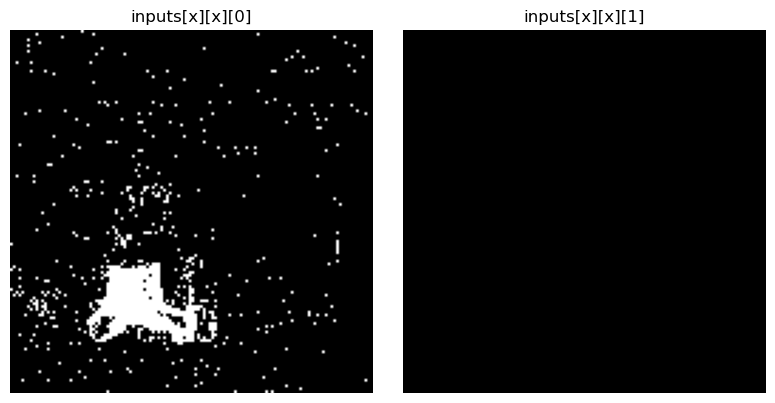

MergePolarities가 적용된 경우, inputs[x][x][0]은 양극성의 합입니다.
MergePolarities가 적용되었다고 해서 channel 차원이 1이 되는 것은 아니고,
그냥 두번째 채널의 모든 값이 0이 되는 것입니다.


In [4]:
for inputs, targets in train_loader:
    
    print("inputs.shape :", inputs.shape, '[batch, time, channel, height, width]')   # 전체 배치 크기

    print("targets.shape:", targets.shape, '[batch]')  # 라벨 shape
    print("1st sample shape:", inputs[0].shape, '[time, channel, height, width]')  # 배치에서 첫 번째 샘플

    img0 = inputs[0][0][0].cpu().numpy()  # 첫 번째 이미지
    img1 = inputs[0][0][1].cpu().numpy()  # 두 번째 이미지

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img0, cmap='gray')
    plt.title("inputs[x][x][0]")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img1, cmap='gray')
    plt.title("inputs[x][x][1]")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig("snapshot.png")  # 현재 작업 디렉토리에 저장
    plt.show()

    print('MergePolarities가 적용된 경우, inputs[x][x][0]은 양극성의 합입니다.')
    print('MergePolarities가 적용되었다고 해서 channel 차원이 1이 되는 것은 아니고,\n그냥 두번째 채널의 모든 값이 0이 되는 것입니다.')



    break  # 한 번만 보기 위해 break


### ./tonic_custom/datasets/dvsgesture.py
### 위 파일 코드의 class DVSGesture(Dataset) 를 보시면 아래 사진처럼
### 제가 좀 커스텀 해놓았습니다. 여기서 dvs_clipping과 DVS-Gesture 11번째 클래스를 배제하는 exclude_class 진행합니다.

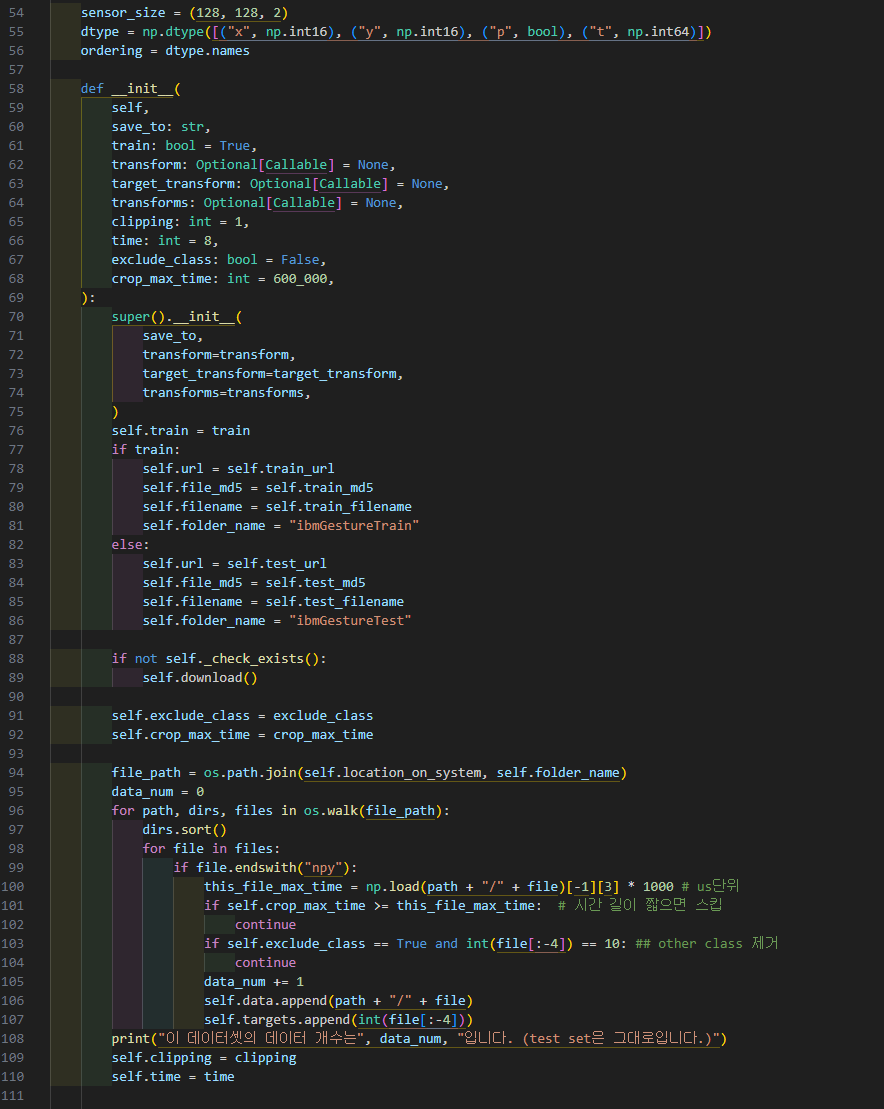

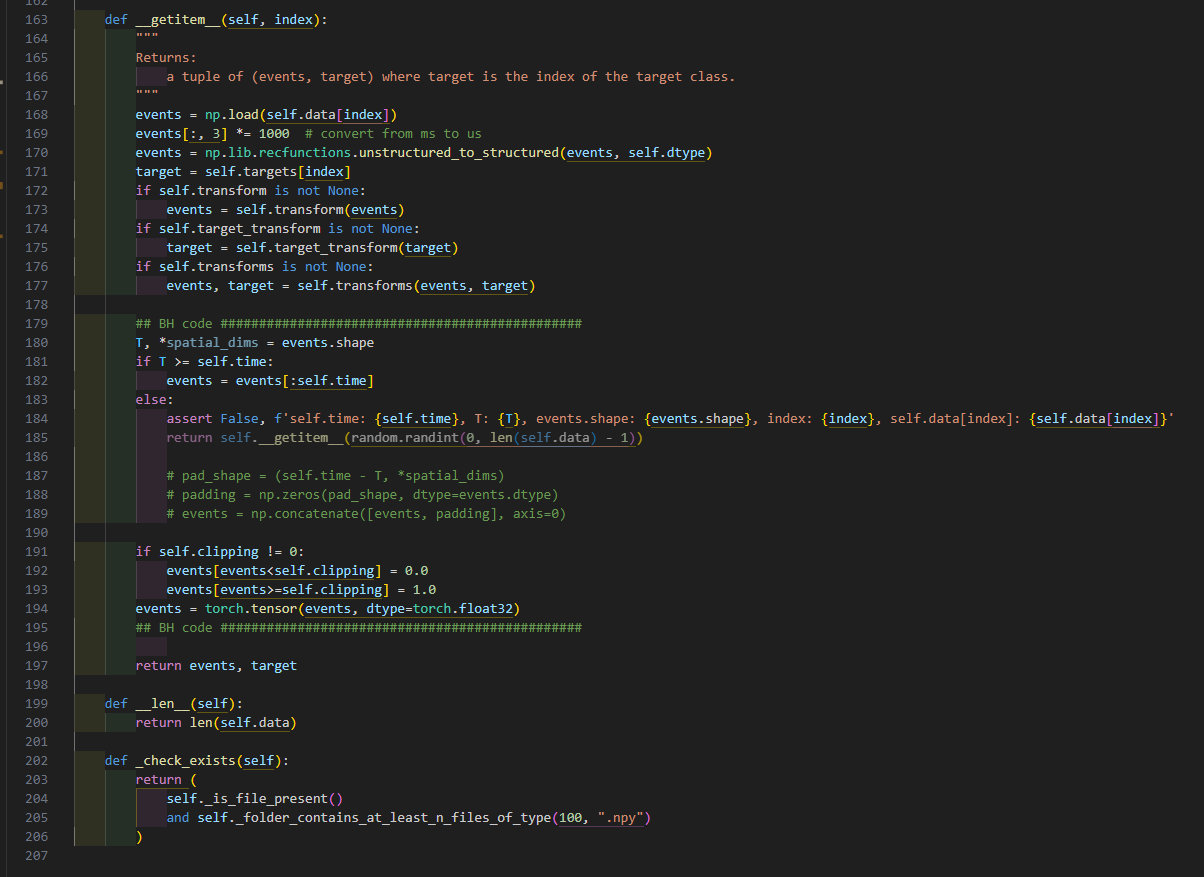